In [8]:
#Importing relevant libraries
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
#Connecting to the database
conn_str = ('DRIVER={ODBC Driver 17 for SQL Server};Server=analiza.database.windows.net;Database=AnalizaDB;UID=qa3107;PWD=fA8r2J2_DZH<;')
conn = pyodbc.connect(conn_str)

In [10]:
#Data Collection And Loading
datasets_names= ['Products','Suppliers','[Order Details]','Categories','Territories','Region','EmployeeTerritories','Employees','Orders','Shippers','Customers']
dataframes = [] #a list of all dataframes loaded, later used for quick review of all datasets loaded. 
def get_dataset(dataset):
    dataset = pd.read_sql(f"SELECT * FROM Northwind.{dataset}", conn)
    return dataset

for dataset in datasets_names:
    dataframe = get_dataset(dataset)
    dataframe.name = f'{dataset}' #Adding a name for each dataframe for later readability
    dataframes.append(dataframe) 

conn.close

C:\Users\ys170\AppData\Local\Temp\ipykernel_22136\3349389208.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(f"SELECT * FROM Northwind.{dataset}", conn)


<function Connection.close()>

In [11]:
#Making sure all data was loaded properly

#looking for 11 dataframes 
print(len(dataframes)) 
for df in dataframes:
    print(type(df))

#Making sure each dataset was loaded at full size with all fields and columns. 
for df in dataframes:
    print(df.name)
    print(df.shape)
    print(df.info())
    print("--------\n")

11
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
Products
(77, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ProductID        77 non-null     int64  
 1   ProductName      77 non-null     object 
 2   SupplierID       77 non-null     int64  
 3   CategoryID       77 non-null     int64  
 4   QuantityPerUnit  77 non-null     object 
 5   UnitPrice        77 non-null     float64
 6   UnitsInStock     77 non-null     int64  
 7   UnitsOnOrder     77 non-null     int64 

In [12]:
#Isolating each dataset 

Products = dataframes[0]
Suppliers = dataframes[1]
OrderDetails = dataframes[2]
Categories = dataframes[3]
Territories = dataframes[4]
Region = dataframes[5]
EmployeeTerritories = dataframes[6]
Employees = dataframes[7]
Orders = dataframes[8]
Shippers = dataframes[9]
Customers = dataframes[10]


In [13]:
#Data Cleaning and Preprocessing 

#Renaming [Order Details] both on the isolated dataframe and on the dataframes list
OrderDetails.name = 'OrderDetails'
dataframes[2].name = 'OrderDetails'

#Renaming UnitPrice column in Products to improve clarity.
Products.rename(columns= {'UnitPrice':'UnitCost'},inplace=True)
#Renaming Shipvia column in Orders to improve clarity
Orders.rename(columns= {'ShipVia':'ShipperID'},inplace=True)



Empty DataFrame
Columns: [ProductID, OrderCount, ProductName]
Index: []
Empty DataFrame
Columns: [ProductID, OrderCount, ProductName]
Index: []
   ProductID  OrderCount             ProductName
0         59          54    Raclette Courdavault
1         31          51       Gorgonzola Telino
2         60          51       Camembert Pierrot
3         24          51      Guaranב Fantבstica
4         56          50  Gnocchi di nonna Alice
    ProductID  OrderCount                ProductName
76          9           5            Mishi Kobe Niku
74         15           6               Genen Shouyu
73         37           6                 Gravad lax
75         48           6                  Chocolade
72         66           8  Louisiana Hot Spiced Okra


C:\Users\ys170\AppData\Local\Temp\ipykernel_22136\3153525427.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(bottom_bin['ProductName'], rotation=45, ha='right')


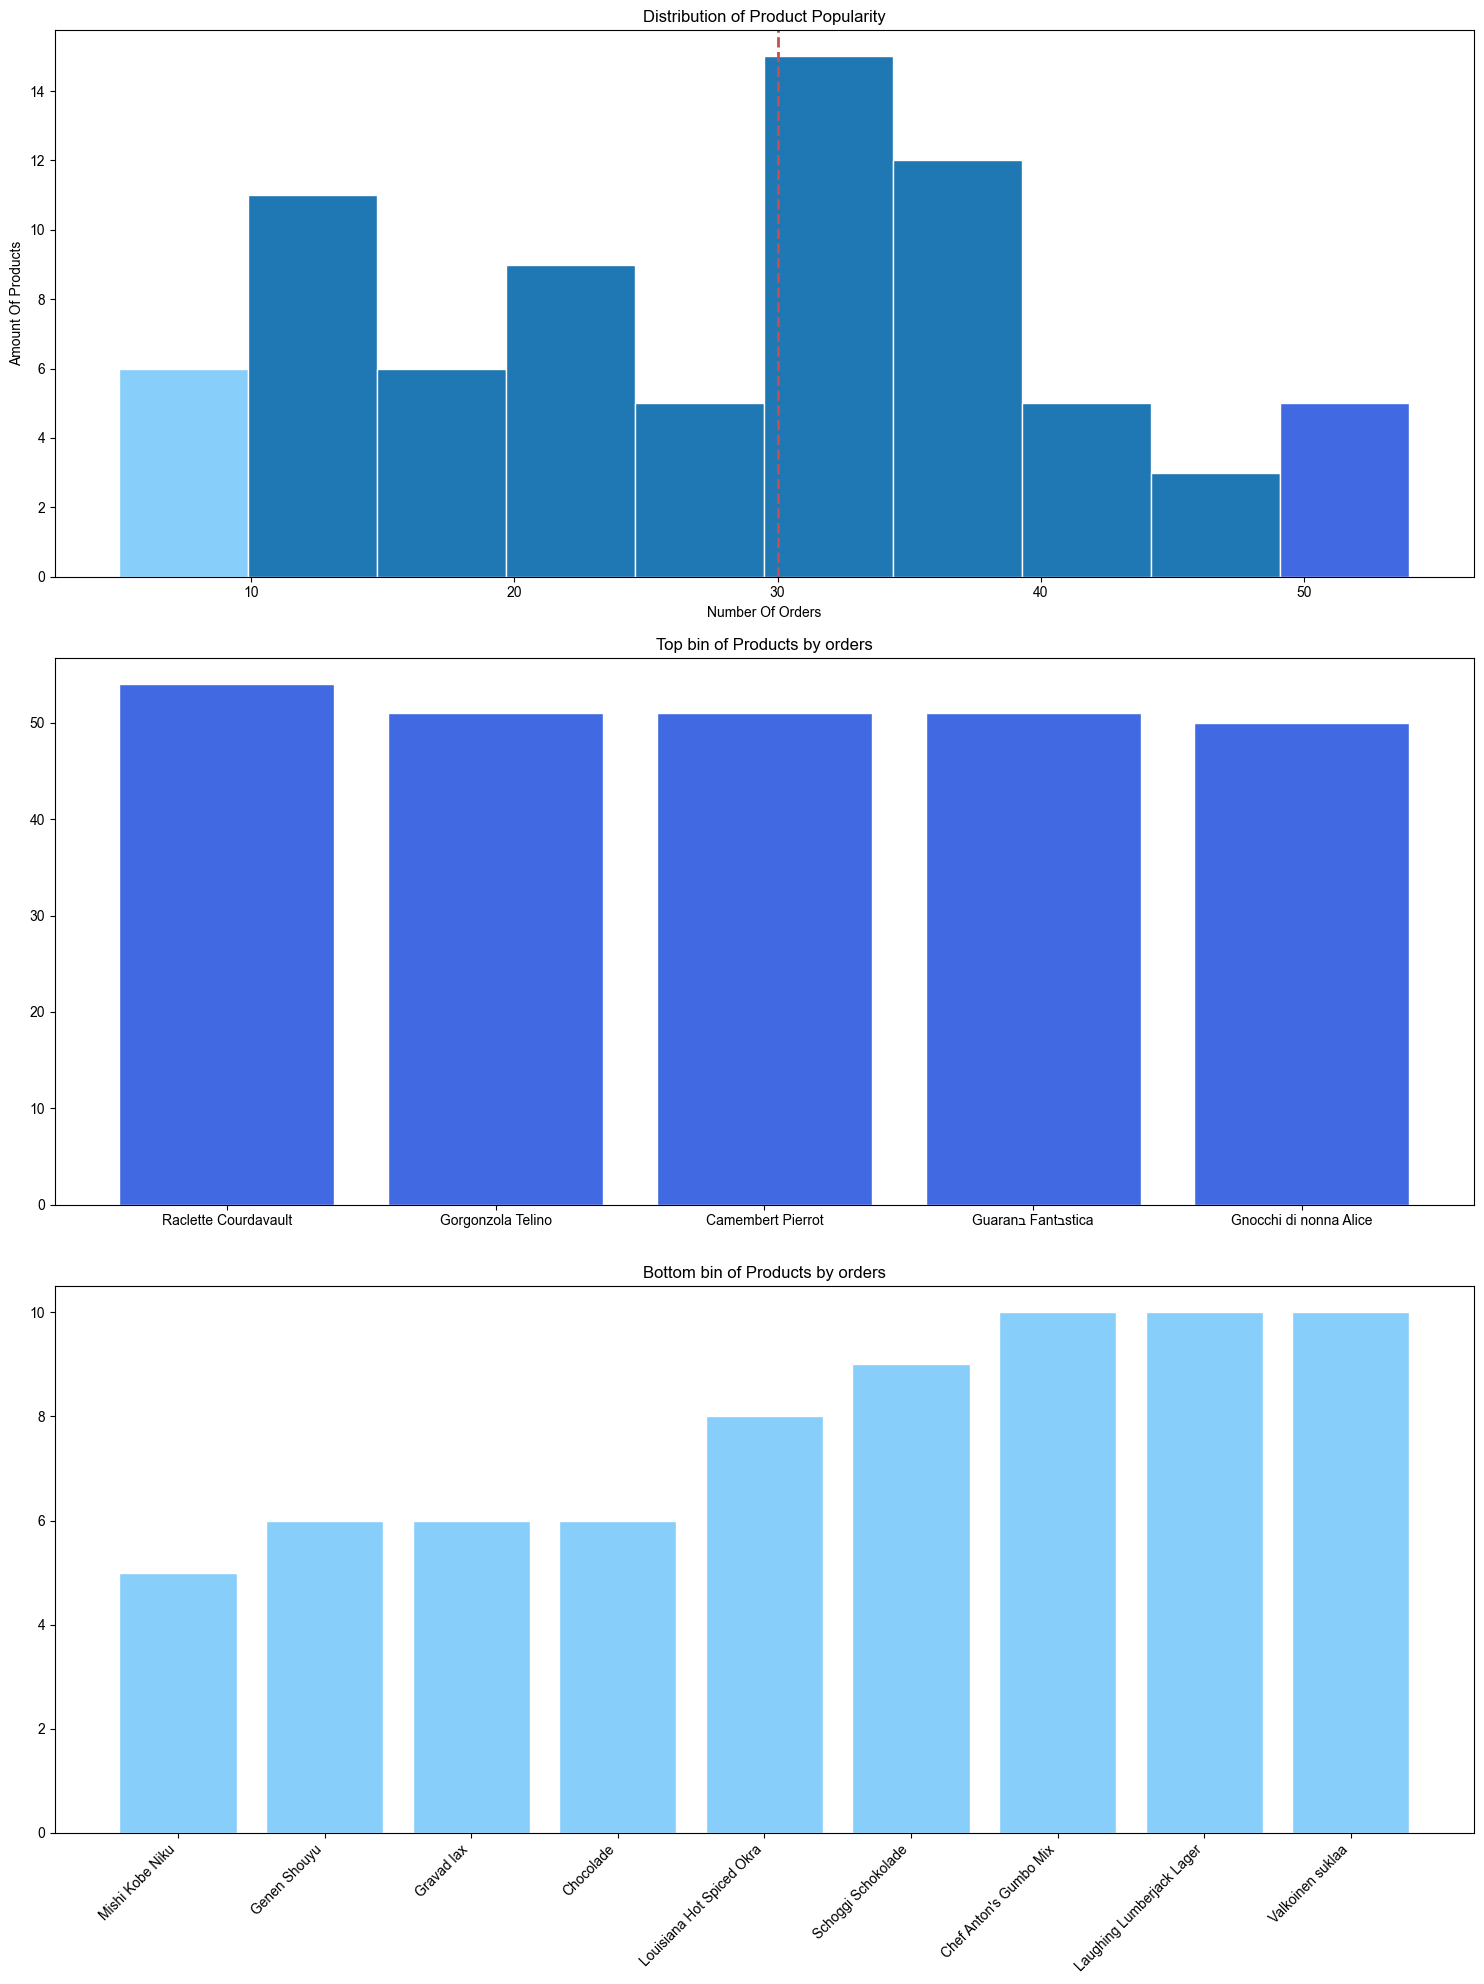

In [14]:
#What are the most popular products? Product statistics

orders_per_product = OrderDetails.groupby('ProductID')['OrderID'].count()
orders_per_product.sort_values(ascending=False,inplace=True)

df_full = pd.merge(orders_per_product,Products[['ProductID','ProductName']],on='ProductID')
df_full.rename(columns={'OrderID':'OrderCount'},inplace= True)

#A function for getting outliers statistcs 
def get_outliers(data,colname):
    data_range = data[colname]
    median = np.percentile(data_range,50)
    Q3 = np.percentile(data_range,75)
    Q1 = np.percentile(data_range,25)
    IQR = Q3- Q1
    high_outlier = Q3 + (1.5*IQR)
    low_outlier = Q1 - (1.5*IQR)
    results= {
        'median':median,
        'Q3':Q3,
        'Q1':Q1,
        'IQR':IQR,
        'ligh_outlier':high_outlier,
        'low_outlier':low_outlier,
        'df_high_outliers':data[data[colname]>high_outlier],
        'df_low_outliers':data[data[colname]<low_outlier]
    }
    return results

#Calculating Outliers
outliers= get_outliers(df_full,'OrderCount')
print(outliers['df_high_outliers'])
print(outliers['df_low_outliers'])

#Creating a bar graph for each of the marginal bins
top_bin = df_full[df_full['OrderCount']>=50]
bottom_bin = df_full[df_full['OrderCount']<=10]
bottom_bin=bottom_bin.sort_values('OrderCount',ascending=True)
print(top_bin.head())#Top bin of distribution
print(bottom_bin.head())#Bottom bin of distribution

fig,axs =plt.subplots(3,1,figsize=(15,20))
sns.set_theme()

#Creating the set of graphs
axs[0].hist(df_full['OrderCount'],bins=10)
axs[0].set_title("Distribution of Product Popularity")
axs[0].set_xlabel('Number Of Orders')
axs[0].set_ylabel('Amount Of Products')
axs[0].patches[0].set_facecolor('lightskyblue')
axs[0].patches[-1].set_facecolor('royalblue')
axs[0].axvline(x=outliers['median'], color='r', linestyle='--', linewidth=2, label='Median')
axs[2].bar(bottom_bin['ProductName'],bottom_bin['OrderCount'],color = 'lightskyblue')
axs[2].set_xticklabels(bottom_bin['ProductName'], rotation=45, ha='right')
axs[2].set_title("Bottom bin of Products by orders")
axs[1].bar(top_bin['ProductName'],top_bin['OrderCount'],color = 'royalblue')
axs[1].set_title("Top bin of Products by orders")

plt.tight_layout()

Empty DataFrame
Columns: [UniqueCustomers, RepeatCustomerCount, RPR]
Index: []
Empty DataFrame
Columns: [UniqueCustomers, RepeatCustomerCount, RPR]
Index: []
   ProductID                 ProductName  UnitsInStock  Discontinued  \
0          8  Northwoods Cranberry Sauce             6         False   
1          9             Mishi Kobe Niku            29          True   
2         15                Genen Shouyu            39         False   
3         22         Gustaf's Knהckebrצd           104         False   
4         27          Schoggi Schokolade            49         False   
5         37                  Gravad lax            11         False   
6         48                   Chocolade            15         False   
7         66   Louisiana Hot Spiced Okra             4         False   
8         67   Laughing Lumberjack Lager            52         False   

   OrderCount  
0          13  
1           5  
2           6  
3          14  
4           9  
5           6  
6        

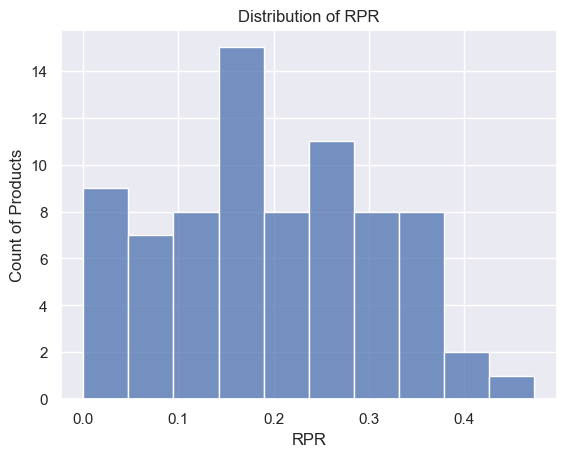

In [15]:
#Calculating RPR (Repeat Purchase Rate)

product_customers = OrderDetails.loc[:,['OrderID','ProductID']]
product_customers = pd.merge(product_customers,Orders[['OrderID','CustomerID']],on='OrderID')

#calculating unique customers per product
product_unique_customers=product_customers.groupby('ProductID').agg(UniqueCustomers=('CustomerID','nunique'))

#calculating repeating customers per product
product_repeat_customers = product_customers.groupby('ProductID')['CustomerID'].agg(RepeatCustomerCount=lambda x: (x.value_counts()>1).sum())

#Calculating RPR
df_rpr = pd.merge(product_unique_customers,product_repeat_customers,on='ProductID')
df_rpr['RPR']=df_rpr.apply(lambda row: row['RepeatCustomerCount']/row['UniqueCustomers'],axis=1)
df_rpr.sort_values(by='RPR',ascending=False,inplace=True)
rpr_outliers = get_outliers(df_rpr,'RPR')
print(rpr_outliers['df_high_outliers'])
print(rpr_outliers['df_low_outliers']) #no outliers

#Creating a list of all products with 0 RPR.
no_repeating_products = df_rpr.loc[(df_rpr['RPR']==0),['RPR']]
filtered_products = Products.loc[Products['ProductID'].isin(no_repeating_products.index),['ProductID','ProductName','UnitsInStock','Discontinued']]
filtered_products = pd.merge(filtered_products,df_full[['ProductID','OrderCount']])
print(filtered_products)

#Presenting the distribution of RPRs

sns.set_theme()
sns.histplot(df_rpr['RPR'],bins=10)
plt.ylabel('Count of Products')
plt.title('Distribution of RPR')
plt.savefig('RPR_distribution.png')

C:\Users\ys170\AppData\Local\Temp\ipykernel_22136\2836245740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Orders_cleaned['ShippingTime']= Orders_cleaned['ShippedDate']-Orders_cleaned['OrderDate']


<Axes: xlabel='ShippingTime', ylabel='Count'>

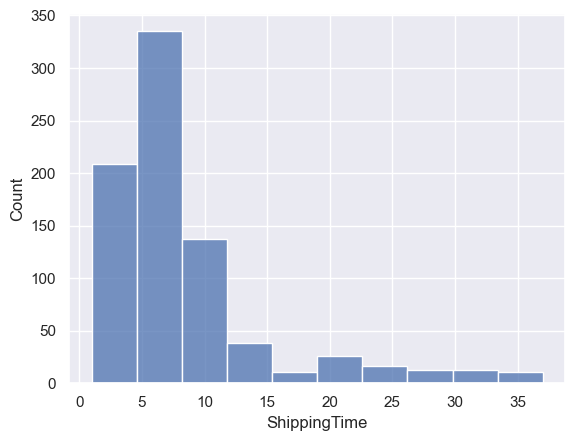

In [ ]:
#Delivery time distribution
#checking for nulls
Orders[Orders['ShippedDate'].isnull()]
Orders.sort_values(by='ShippedDate',ascending=False)
#by comparing latest reported dates to the order date of orders which don't have a shipped date I conclude that orders that lack shipped date are orders not yet shipped. Therefore, I will remove them to continue analysis.
Orders_cleaned = Orders.dropna(subset='ShippedDate')

Orders_cleaned['ShippingTime']= Orders_cleaned['ShippedDate']-Orders_cleaned['OrderDate']
Orders_cleaned['ShippingTime'].dt.days

sns.set_theme()
sns.histplot(Orders_cleaned['ShippingTime'].dt.days,bins=10)